## Randon forest aplicado a previsão de retornos

In [77]:
### Importando bibliotecas
import pandas as pd
import numpy as np
import ta  ### biblioteca para analise de indicadores técnicos
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt


In [78]:
df = pd.read_excel('economatica.xlsx', parse_dates=True, index_col=0, skiprows=3)
df.rename(columns={'Volume$':'Volume'}, inplace=True)
df.head()

,Q Negs,Q Títs,Volume,Fechamento,Abertura,Mínimo,Máximo,Médio
Data,,,,,,,,
2010-01-04,13531,13303600,493660216,23.135237,22.905869,22.825280,23.135237,23.005055
2010-01-05,22782,21396400,794327759,22.936865,23.172432,22.812881,23.203428,23.011254
2010-01-06,18647,18720600,697345692,23.246822,22.812881,22.812881,23.246822,23.091843
2010-01-07,12720,10964600,408386356,23.029852,23.104242,22.980259,23.215826,23.091843
2010-01-08,14192,14624200,542061948,22.905869,23.036051,22.850076,23.178631,22.980259


#### Criando features

In [79]:
df['Retornos'] = df.Fechamento.pct_change() ## retornos
df['Kama'] = ta.momentum.KAMAIndicator(close=df.Fechamento, window=21).kama() ## indicador Kama
df['ROC'] = ta.momentum.ROCIndicator(close=df.Fechamento, window=12).roc()
df['RSI'] = ta.momentum.RSIIndicator(close=df.Fechamento, window=14).rsi()
df['Stoch'] = ta.momentum.StochasticOscillator(close=df.Fechamento, high=df.Máximo, low=df.Mínimo, window=14, smooth_window=3).stoch()
df['Chaikin_money'] = ta.volume.ChaikinMoneyFlowIndicator(high=df.Máximo, low=df.Mínimo, close=df.Fechamento, volume=df.Volume, window=20).chaikin_money_flow()
df['Force_index'] = ta.volume.ForceIndexIndicator(close=df.Fechamento, volume=df.Volume, window=13).force_index() 
df['Normal'] = (df.Fechamento - df.Mínimo) / (df.Máximo - df.Mínimo) ## mede a % de quanto um dia fechou da máxima ou mínima

In [80]:
df.head()

,Q Negs,Q Títs,Volume,Fechamento,Abertura,Mínimo,Máximo,Médio,Retornos,Kama,ROC,RSI,Stoch,Chaikin_money,Force_index,Normal
Data,,,,,,,,,,,,,,,,
2010-01-04,13531,13303600,493660216,23.135237,22.905869,22.825280,23.135237,23.005055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
2010-01-05,22782,21396400,794327759,22.936865,23.172432,22.812881,23.203428,23.011254,-0.008574,NaN,NaN,NaN,NaN,NaN,NaN,0.317460
2010-01-06,18647,18720600,697345692,23.246822,22.812881,22.812881,23.246822,23.091843,0.013514,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
2010-01-07,12720,10964600,408386356,23.029852,23.104242,22.980259,23.215826,23.091843,-0.009333,NaN,NaN,NaN,NaN,NaN,NaN,0.210526
2010-01-08,14192,14624200,542061948,22.905869,23.036051,22.850076,23.178631,22.980259,-0.005384,NaN,NaN,NaN,NaN,NaN,NaN,0.169811


### Tratando os dados

In [81]:
df = df.dropna() ## excluindo valores nulos
X = df[['Q Negs', 'Q Títs', 'Volume', 'Fechamento', 'Abertura', 'Mínimo', 'Máximo', 'Médio', 'Kama', 'ROC', 'RSI', 'Stoch', 'Chaikin_money', 'Force_index', 'Normal']] ## criando as features
y = np.where(df['Fechamento'].shift(-1) > df['Fechamento'], 1, -1) ## criando target

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

### Criando o pipeline com os modelos

In [83]:
scaler = StandardScaler()
dt = DecisionTreeClassifier()
pipeline = Pipeline(steps=[('Scaler',scaler),
                    ('Decision_Tree', dt)])
                    
criterion = ["gini", 'entropy']
max_depth = [2, 4, 6, 8, 10]
random_state = [3, 4]


In [84]:
### Criando parametros para comparação 
parameters = dict(Decision_Tree__criterion=criterion, 
                    Decision_Tree__max_depth=max_depth,
                    Decision_Tree__random_state=random_state)
parameters

{'Decision_Tree__criterion': ['gini', 'entropy'],
 'Decision_Tree__max_depth': [2, 4, 6, 8, 10],
 'Decision_Tree__random_state': [3, 4]}

### Rodando modelo

In [85]:
clf_GS = GridSearchCV(pipeline, param_grid=parameters, scoring='accuracy', cv=5)
clf_GS.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('Decision_Tree',
                                        DecisionTreeClassifier())]),
             param_grid={'Decision_Tree__criterion': ['gini', 'entropy'],
                         'Decision_Tree__max_depth': [2, 4, 6, 8, 10],
                         'Decision_Tree__random_state': [3, 4]},
             scoring='accuracy')

In [86]:
clf_GS.best_params_

{'Decision_Tree__criterion': 'gini',
 'Decision_Tree__max_depth': 6,
 'Decision_Tree__random_state': 3}

In [87]:
clf_GS.score(X_train, y_train)

0.6106048053024027

In [88]:
y_predic = clf_GS.predict(X_test)

In [89]:
accuracy = accuracy_score(y_test, y_predic)
accuracy

0.5082781456953642

In [90]:
report = classification_report(y_test, clf_GS.predict(X_test))
print(report)

              precision    recall  f1-score   support

          -1       0.50      0.38      0.43       298
           1       0.51      0.63      0.57       306

    accuracy                           0.51       604
   macro avg       0.51      0.51      0.50       604
weighted avg       0.51      0.51      0.50       604



### Analisando estratégia

In [91]:
df['Strategy_returns'] = df['Retornos'].shift(-1) * clf_GS.predict(X) ### retorno da estratégia
### Calculando Drawdown
strategy = df['Strategy_returns'][X_train.shape[0]:]
wealth = 1000*(1+strategy).cumprod()
peaks = wealth.cummax()
drawdown = (wealth-peaks)/peaks

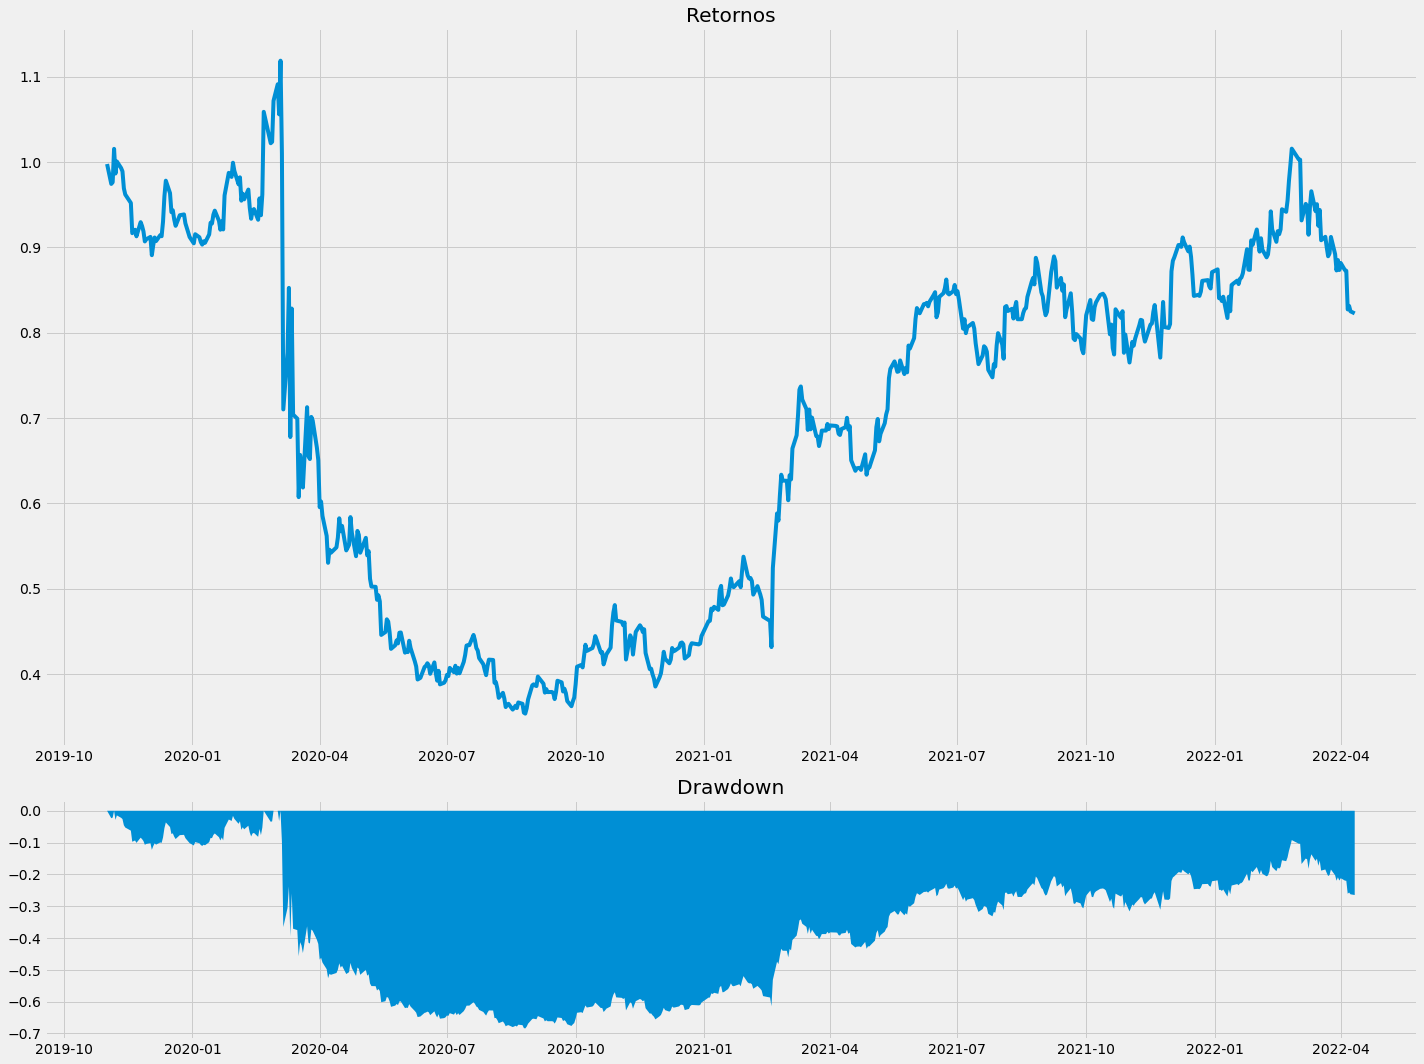

In [92]:
plt.style.use('fivethirtyeight')
f, (a0, a1) = plt.subplots(2, 1, figsize=(20, 15), gridspec_kw={'height_ratios': [3, 1]})
a0.plot((df['Strategy_returns'][X_train.shape[0]:]+1).cumprod())
a0.set_title('Retornos')
a1.plot(drawdown, linewidth=0)
a1.set_title('Drawdown')
a1.fill_between(drawdown.index, drawdown, alpha=1)
f.tight_layout()
